In this notebook, we will apply NeuralForecast to perform a supervised Remaining Useful Life (RUL) estimation on the classic PHM2008 aircraft degradation dataset.

In [ ]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
plt.rcParams['font.family'] = 'serif'

from neuralforecast.models import NBEATSx, MLP
from neuralforecast import NeuralForecast
#from neuralforecast.losses.pytorch import DistributionLoss, HuberMQLoss, MQLoss
from neuralforecast.losses.pytorch import HuberLoss, MAE



In [ ]:
from phm2008 import PHM2008


In [3]:
Y_train_df, Y_test_df = PHM2008.load(directory='./data', group='FD001', clip_rul=False)
Y_train_df


,unique_id,ds,s_2,s_3,s_4,s_7,s_8,s_9,s_11,s_12,s_13,s_14,s_15,s_17,s_20,s_21,y
0,1,1,641.82,1589.70,1400.60,554.36,2388.06,9046.19,47.47,521.66,2388.02,8138.62,8.4195,392,39.06,23.4190,191
1,1,2,642.15,1591.82,1403.14,553.75,2388.04,9044.07,47.49,522.28,2388.07,8131.49,8.4318,392,39.00,23.4236,190
2,1,3,642.35,1587.99,1404.20,554.26,2388.08,9052.94,47.27,522.42,2388.03,8133.23,8.4178,390,38.95,23.3442,189
3,1,4,642.35,1582.79,1401.87,554.45,2388.11,9049.48,47.13,522.86,2388.08,8133.83,8.3682,392,38.88,23.3739,188
4,1,5,642.37,1582.85,1406.22,554.00,2388.06,9055.15,47.28,522.19,2388.04,8133.80,8.4294,393,38.90,23.4044,187
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20626,100,196,643.49,1597.98,1428.63,551.43,2388.19,9065.52,48.07,519.49,2388.26,8137.60,8.4956,397,38.49,22.9735,4
20627,100,197,643.54,1604.50,1433.58,550.86,2388.23,9065.11,48.04,519.68,2388.22,8136.50,8.5139,395,38.30,23.1594,3
20628,100,198,643.42,1602.46,1428.18,550.94,2388.24,9065.90,48.09,520.01,2388.24,8141.05,8.5646,398,38.44,22.9333,2
20629,100,199,643.23,1605.26,1426.53,550.68,2388.25,9073.72,48.39,519.67,2388.23,8139.29,8.5389,395,38.29,23.0640,1


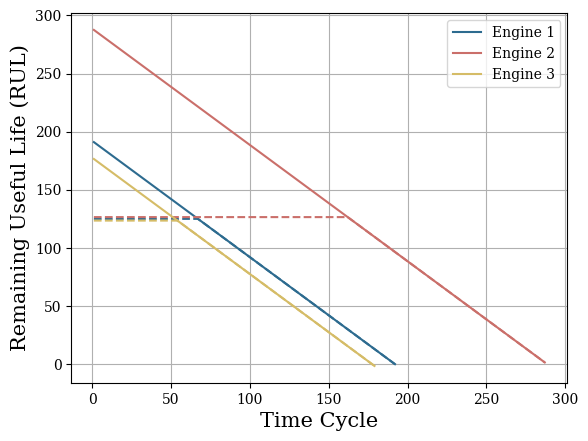

In [4]:
plot_df1 = Y_train_df[Y_train_df['unique_id']==1]
plot_df2 = Y_train_df[Y_train_df['unique_id']==2]
plot_df3 = Y_train_df[Y_train_df['unique_id']==3]

plt.plot(plot_df1.ds, np.minimum(plot_df1.y, 125), color='#2D6B8F', linestyle='--')
plt.plot(plot_df1.ds, plot_df1.y, color='#2D6B8F', label='Engine 1')

plt.plot(plot_df2.ds, np.minimum(plot_df2.y, 125)+1.5, color='#CA6F6A', linestyle='--')
plt.plot(plot_df2.ds, plot_df2.y+1.5, color='#CA6F6A', label='Engine 2')

plt.plot(plot_df3.ds, np.minimum(plot_df3.y, 125)-1.5, color='#D5BC67', linestyle='--')
plt.plot(plot_df3.ds, plot_df3.y-1.5, color='#D5BC67', label='Engine 3')

plt.ylabel('Remaining Useful Life (RUL)', fontsize=15)
plt.xlabel('Time Cycle', fontsize=15)
plt.legend()
plt.grid()


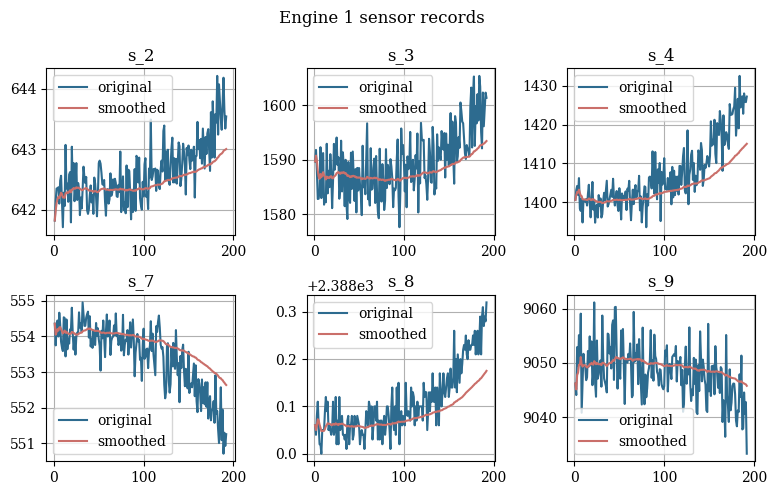

In [5]:
def smooth(s, b = 0.98):
    v = np.zeros(len(s)+1) #v_0 is already 0.
    bc = np.zeros(len(s)+1)
    for i in range(1, len(v)): #v_t = 0.95
        v[i] = (b * v[i-1] + (1-b) * s[i-1]) 
        bc[i] = 1 - b**i
    sm = v[1:] / bc[1:]
    return sm

unique_id = 1
plot_df = Y_train_df[Y_train_df.unique_id == unique_id].copy()

fig, axes = plt.subplots(2,3, figsize = (8,5))
fig.tight_layout()

j = -1
#, 's_11', 's_12', 's_13', 's_14', 's_15', 's_17', 's_20', 's_21'
for feature in ['s_2', 's_3', 's_4', 's_7', 's_8', 's_9']:
    if ('s' in feature) and ('smoothed' not in feature):
        j += 1
        axes[j // 3, j % 3].plot(plot_df.ds, plot_df[feature], 
                                 c = '#2D6B8F', label = 'original')
        axes[j // 3, j % 3].plot(plot_df.ds, smooth(plot_df[feature].values), 
                                 c = '#CA6F6A', label = 'smoothed')
        #axes[j // 3, j % 3].plot([10,10],[0,1], c = 'black')
        axes[j // 3, j % 3].set_title(feature)
        axes[j // 3, j % 3].grid()
        axes[j // 3, j % 3].legend()
        
plt.suptitle(f'Engine {unique_id} sensor records')
plt.tight_layout()


In [6]:
Y_train_df, Y_test_df = PHM2008.load(directory='./data', group='FD001', clip_rul=True)


/Users/mojtabaaskarzadeh/TimeSeriesForecasting/phm2008.py:178: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  Y_train_df['y'].clip(upper=125, inplace=True)
/Users/mojtabaaskarzadeh/TimeSeriesForecasting/phm2008.py:179: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when 

In [7]:
Y_test_df[Y_test_df["unique_id"]==1]

,unique_id,ds,s_2,s_3,s_4,s_7,s_8,s_9,s_11,s_12,s_13,s_14,s_15,s_17,s_20,s_21,y
0,1,1,643.02,1585.29,1398.21,553.90,2388.04,9050.17,47.20,521.72,2388.03,8125.55,8.4052,392,38.86,23.3735,125
1,1,2,641.71,1588.45,1395.42,554.85,2388.01,9054.42,47.50,522.16,2388.06,8139.62,8.3803,393,39.02,23.3916,125
2,1,3,642.46,1586.94,1401.34,554.11,2388.05,9056.96,47.50,521.97,2388.03,8130.10,8.4441,393,39.08,23.4166,125
3,1,4,642.44,1584.12,1406.42,554.07,2388.03,9045.29,47.28,521.38,2388.05,8132.90,8.3917,391,39.00,23.3737,125
4,1,5,642.51,1587.19,1401.92,554.16,2388.01,9044.55,47.31,522.15,2388.03,8129.54,8.4031,390,38.99,23.4130,125
5,1,6,642.11,1579.12,1395.13,554.22,2388.00,9050.96,47.26,521.92,2388.08,8127.46,8.4238,392,38.91,23.3467,125
6,1,7,642.11,1583.34,1404.84,553.89,2388.05,9051.39,47.31,522.01,2388.06,8134.97,8.3914,391,38.85,23.3952,125
7,1,8,642.54,1580.89,1400.89,553.59,2388.05,9052.86,47.21,522.09,2388.06,8125.93,8.4213,393,39.05,23.3224,125
8,1,9,641.88,1593.29,1412.28,554.49,2388.06,9048.55,47.37,522.03,2388.05,8134.15,8.4353,391,39.10,23.4521,125
9,1,10,642.07,1585.25,1398.64,554.28,2388.04,9051.95,47.14,522.00,2388.06,8134.08,8.4093,391,38.87,23.3820,125


In [9]:
futr_exog_list =['s_2', 's_3', 's_4', 's_7', 's_8', 's_9', 's_11',
                 's_12', 's_13', 's_14', 's_15', 's_17', 's_20', 's_21']

model = NBEATSx(h=1, input_size=24,
                loss=HuberLoss(),
                scaler_type='robust',
                stack_types=['identity', 'identity', 'identity'],
                dropout_prob_theta=0.5,
                futr_exog_list=futr_exog_list,
                exclude_insample_y = True,
                max_steps=1000)
nf = NeuralForecast(models=[model], freq=4)

nf.fit(df=Y_train_df)

Seed set to 1
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | HuberLoss     | 0      | train
1 | padder_train | ConstantPad1d | 0      | train
2 | scaler       | TemporalNorm  | 0      | train
3 | blocks       | ModuleList    | 3.0 M  | train
-------------------------------------------------------
3.0 M     Trainable params
0         Non-trainable params
3.0 M     Total params
11.914    Total estimated model params size (MB)


Sanity Checking: |                                                                                            …

Training: |                                                                                                   …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

`Trainer.fit` stopped: `max_steps=1000` reached.


In [15]:
Y_train_df[Y_train_df['unique_id']==3]

,unique_id,ds,s_2,s_3,s_4,s_7,s_8,s_9,s_11,s_12,s_13,s_14,s_15,s_17,s_20,s_21,y
479,3,1,642.04,1584.20,1398.13,553.96,2388.06,9056.95,47.14,522.24,2388.00,8138.40,8.4207,391,38.96,23.3205,125
480,3,2,642.66,1587.04,1398.62,554.76,2388.05,9059.67,47.35,522.03,2388.01,8137.38,8.3949,390,39.07,23.4369,125
481,3,3,642.07,1580.75,1401.10,554.51,2388.03,9050.43,46.94,522.16,2388.01,8137.20,8.3820,393,39.03,23.3162,125
482,3,4,642.50,1580.12,1395.76,554.48,2388.07,9060.43,47.44,522.31,2388.07,8139.35,8.3940,391,38.94,23.4901,125
483,3,5,641.97,1581.48,1394.05,554.14,2388.01,9054.36,47.16,522.00,2388.03,8135.99,8.4233,391,38.90,23.4190,125
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
653,3,175,643.15,1603.74,1424.17,551.47,2388.06,9172.76,48.12,520.34,2388.14,8238.86,8.5066,396,38.49,22.9909,4
654,3,176,643.93,1595.61,1438.51,551.93,2388.18,9185.88,47.98,520.91,2388.12,8251.82,8.5245,396,38.49,23.0656,3
655,3,177,643.68,1601.21,1423.50,552.17,2388.13,9191.53,48.10,520.19,2388.16,8249.86,8.5286,397,38.37,23.0336,2
656,3,178,643.66,1606.50,1430.55,551.31,2388.19,9193.98,48.38,520.14,2388.12,8253.84,8.5351,399,38.57,23.1323,1


In [16]:
Y_hat_df = nf.predict(futr_df=Y_test_df).reset_index() # By default last window?

ValueError: There are missing combinations of ids and times in `futr_df`.
You can run the `make_future_dataframe()` method to get the expected combinations or the `get_missing_future(futr_df)` method to get the missing combinations.

In [ ]:
filter_test_df = Y_test_df.groupby('unique_id').tail(31).reset_index()
Y_hat_df2 = nf.cross_validation(df=filter_test_df, n_windows=30, fit_models=False)


In [ ]:
from sklearn.metrics import r2_score
from neuralforecast.losses.numpy import rmse

model_name = repr(nf.models[0])
y_last = Y_test_df[['unique_id', 'y']].groupby('unique_id').last().reset_index()
y_hat_last = Y_hat_df[['unique_id', model_name]].groupby('unique_id').last().reset_index()
y_last = y_last['y']
y_hat_last = y_hat_last[model_name]

rmse_eval = rmse(y=y_last, y_hat=y_hat_last)
r2_eval = r2_score(y_true=y_last, y_pred=y_hat_last)

print(f'{model_name} Prognosis Evaluation')
print(f'RMSE:\t {rmse_eval:.3f}')
print(f'R2:\t {r2_eval:.3f}')


In [ ]:
plt.scatter(y_last, y_hat_last)
plt.xlabel('True RUL', fontsize=15)
plt.ylabel('RUL Prediction', fontsize=15)
plt.grid()


In [ ]:
plot_df1 = Y_hat_df2[Y_hat_df2['unique_id']==1]
plot_df2 = Y_hat_df2[Y_hat_df2['unique_id']==2]
plot_df3 = Y_hat_df2[Y_hat_df2['unique_id']==3]

plt.plot(plot_df1.ds, plot_df1['y'], c='#2D6B8F', label='E1 true RUL')
plt.plot(plot_df1.ds, plot_df1[model_name]+1, c='#2D6B8F', linestyle='--', label='E1 predicted RUL')

plt.plot(plot_df1.ds, plot_df2['y'], c='#CA6F6A', label='E2 true RUL')
plt.plot(plot_df1.ds, plot_df2[model_name]+1, c='#CA6F6A', linestyle='--', label='E2 predicted RUL')

plt.plot(plot_df1.ds, plot_df3['y'], c='#D5BC67', label='E3 true RUL')
plt.plot(plot_df1.ds, plot_df3[model_name]+1, c='#D5BC67', linestyle='--', label='E3 predicted RUL')

plt.legend()
plt.grid()
